# Generative linear models para ver tendencias de COVID-19 en Chile

In [429]:
#Cargamos datos
import pandas as pd

df = pd.read_excel('casos_n.xls').reset_index().rename(columns={1: 'new_cases', 'index': 'day'})
df['total_cases'] = df.new_cases.cumsum()

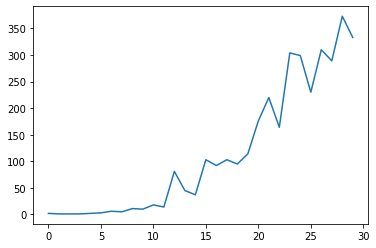

In [430]:
# Los miramos en el grafico
df.new_cases.plot()

In [431]:
# Preparamos X, y
X = np.expand_dims(df.day.to_numpy(), 1)
y = df.new_cases

In [432]:
# FUERA DE USO
# Alternativa para hacer grid search de splines

#gam = LinearGAM(n_splines=25,spline_order=3)
#gam.gridsearch(X, y, n_splines=np.arange(50))

In [433]:
# FUERA DE USO
# Alternativa para hacer grid search de lambadas

#gam = LinearGAM(n_splines=4,spline_order=3).gridsearch(X, y, lam=np.logspace(-12, 12, 5000))

In [512]:
from pygam import LinearGAM, s, f

# Definimos nuetras GAM como una linear de s(0, n_splines=n_splines)
n_splines = 20
gam = LinearGAM(s(0, n_splines=n_splines))

In [513]:
# Hacemos fit
gam.fit(X, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

In [514]:
# Un sumario

gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.2234
Link Function:                     IdentityLink Log Likelihood:                                  -229.4759
Number of Samples:                           30 AIC:                                              477.3985
                                                AICc:                                             486.9344
                                                GCV:                                             1599.8941
                                                Scale:                                             836.999
                                                Pseudo R-Squared:                                   0.9584
Feature Function                  Lam

<ipython-input-514-4bebcc94ea8e>:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


### Ploteamos las predicciones para para el modelo y sus intervalos

In [515]:
# Pongamos fechas bonitas
import datetime

def nday2datetime(nday):
    base_date = datetime.datetime(2020, 3, 2)
    return base_date + datetime.timedelta(days=nday)

def nday2datetime_list(nday_list):
    result = []
    for nday in nday_list:
        result.append(nday2datetime(nday))
        
    return result


df['ds'] = df.day.apply(nday2datetime)
#df.set_index('ds');

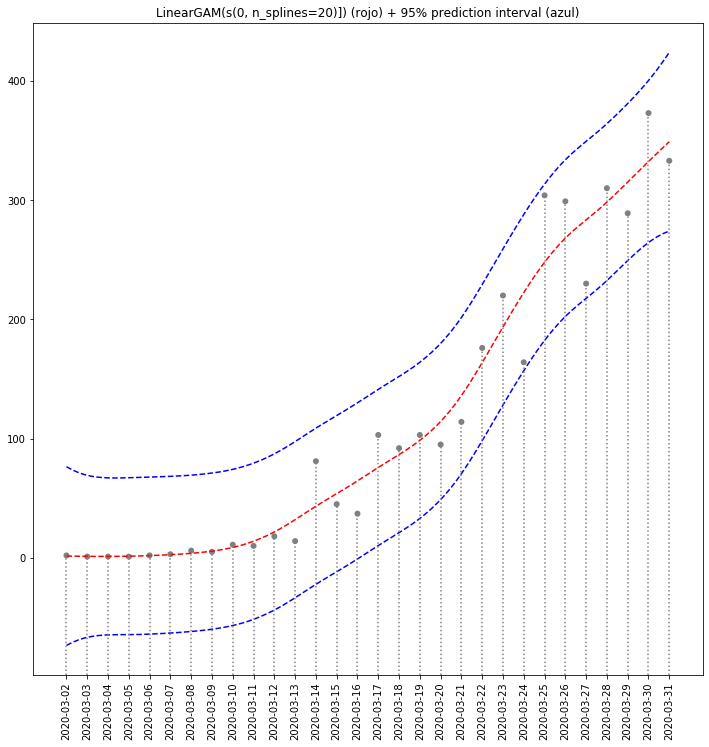

In [516]:
import matplotlib.pyplot as plt

def plot_gam(gam, title, X, y, save = False):
    fig, ax = plt.subplots(figsize=(12, 12))
    #plt.figure(figsize=(12, 12));

    XX = gam.generate_X_grid(0)

    plt.plot(nday2datetime_list(XX[:, 0]), gam.predict(XX), 'r--')
    plt.plot(nday2datetime_list(XX[:, 0]), gam.prediction_intervals(XX), color='b', ls='--')

    plt.scatter(X, y, facecolor='gray', edgecolors='none')
    plt.title(title)
    plt.xticks(X, rotation=90)
    
    # Create transformers for lines
    data2figure_trans = ax.transData
    figure2ax_trans = ax. transAxes.inverted()
    
    for point in zip(X, y.values):
        # Convert point from data to figure cordinate system
        f_point = data2figure_trans.transform([0, point[1]])
        # Convert point from figure to axis coordinate system
        a_point = figure2ax_trans.transform(f_point)
        
        plt.axvline(point[0], ymax=a_point[1], linestyle=':', color='gray')
    if save:
        plt.savefig(f'{title}.png')
    plt.show()
    plt.close()
        
plot_gam(gam, f'LinearGAM(s(0, n_splines={n_splines})]) (rojo) + 95% prediction interval (azul)', df.ds, y)

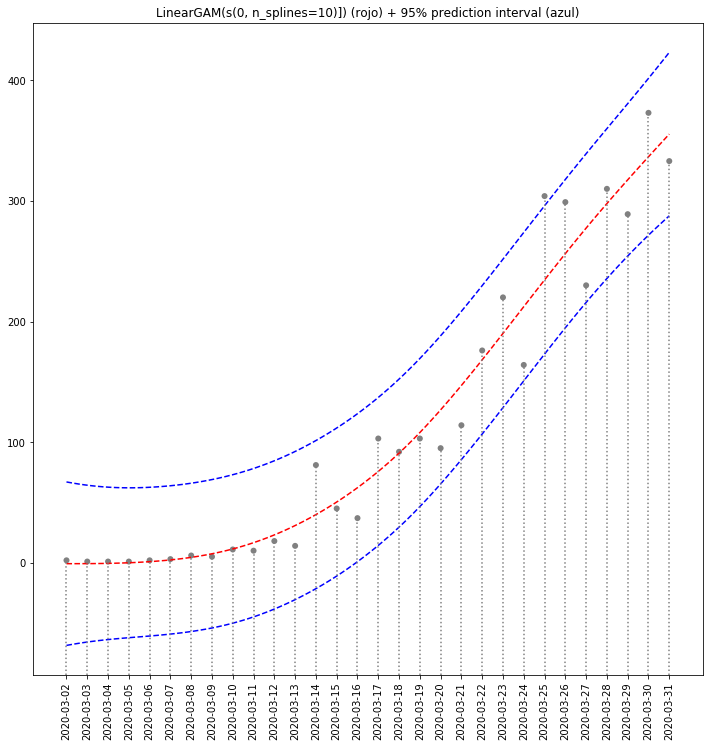

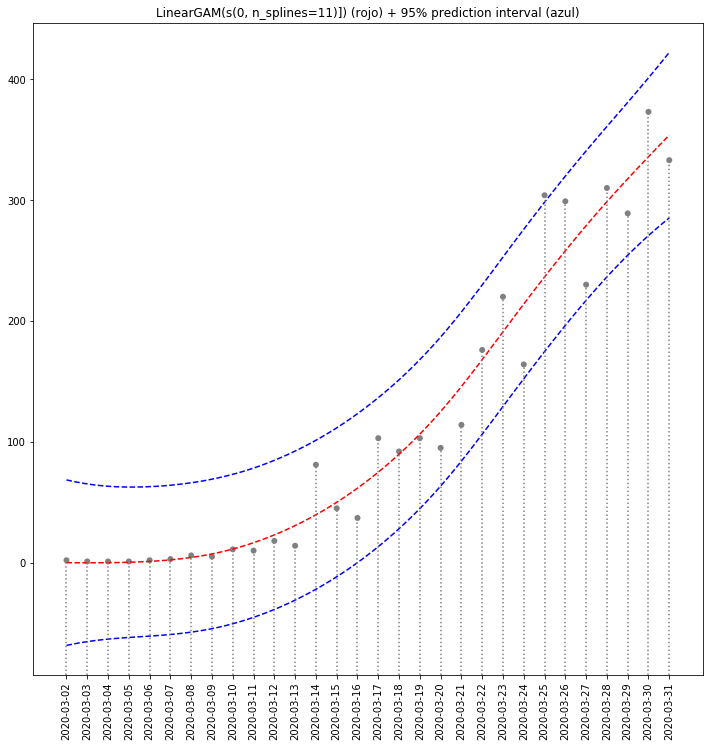

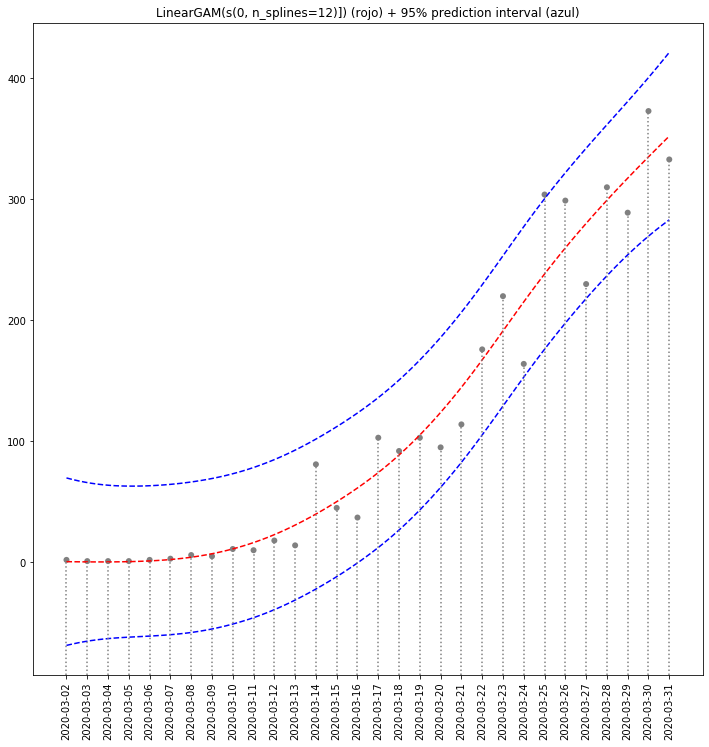

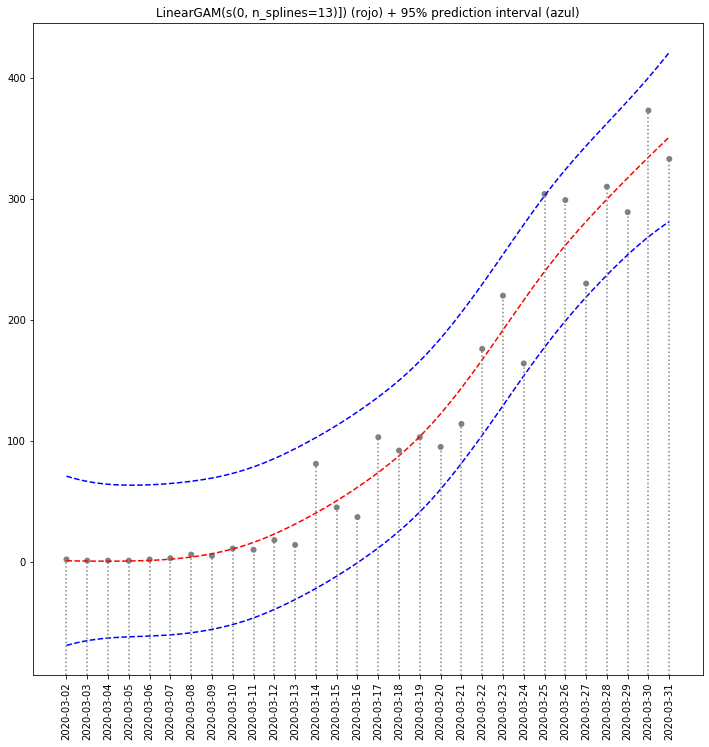

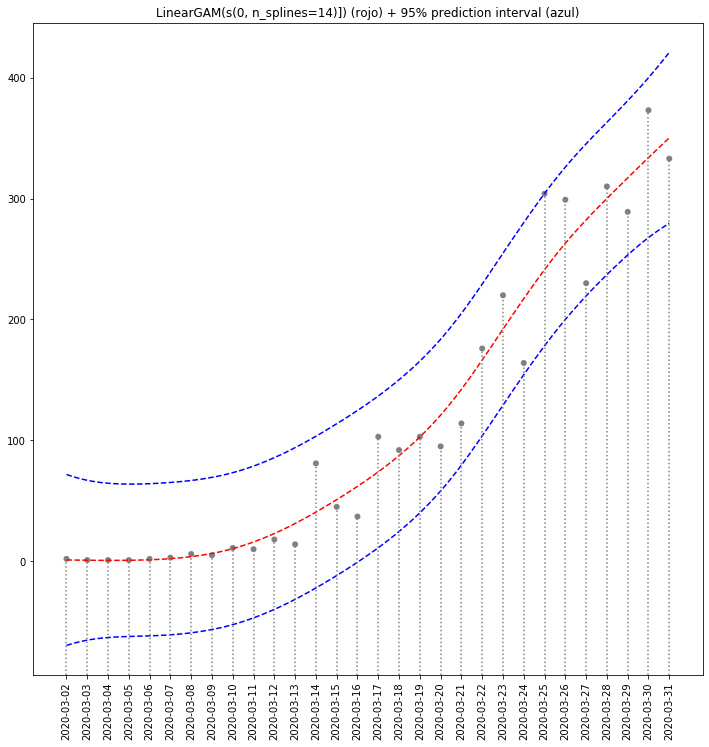

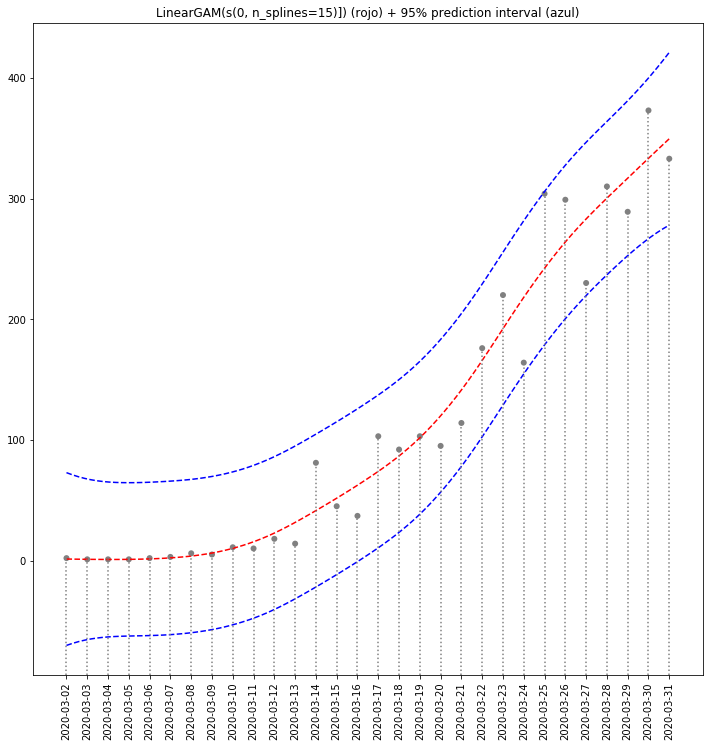

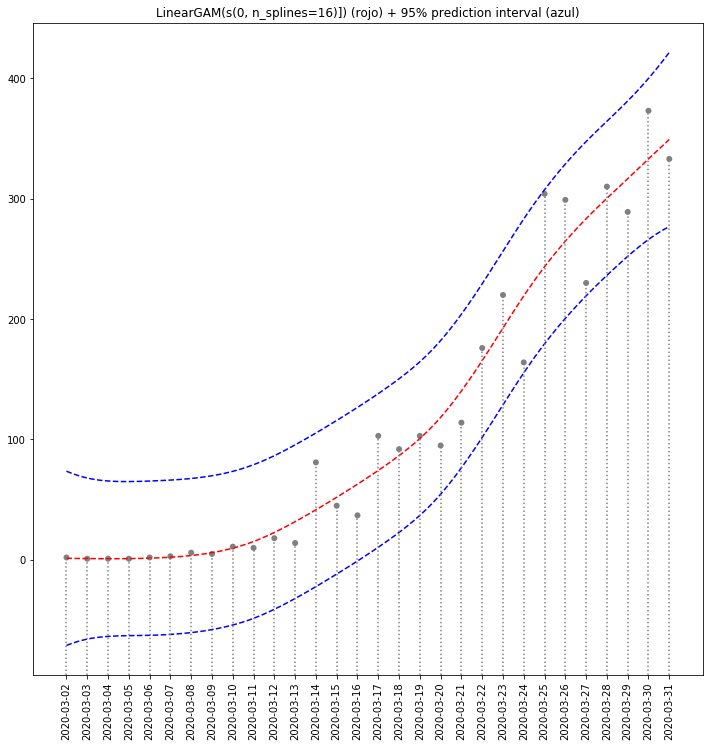

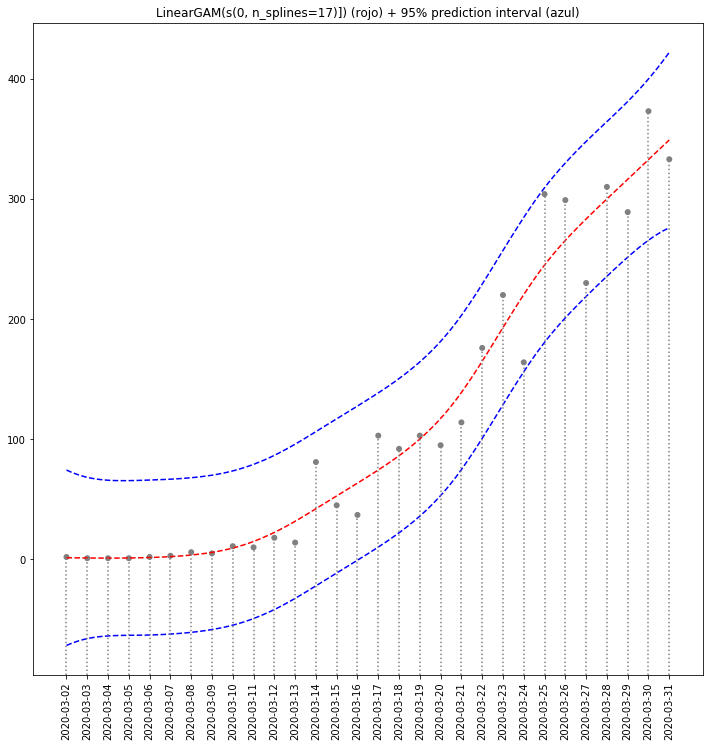

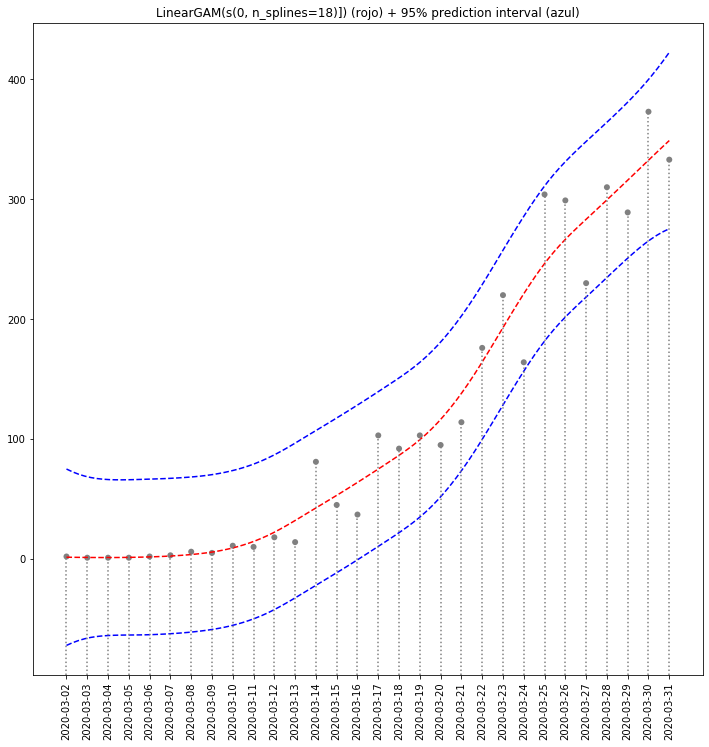

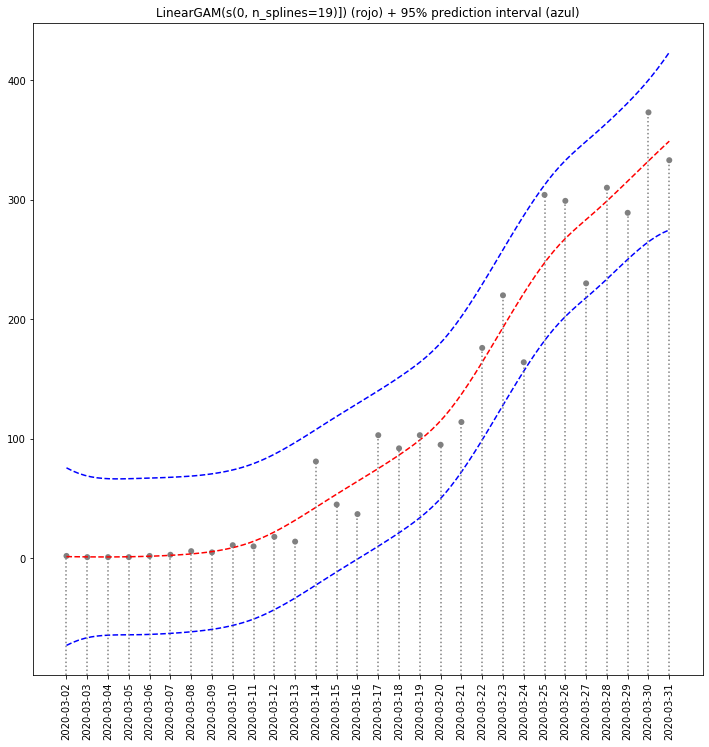

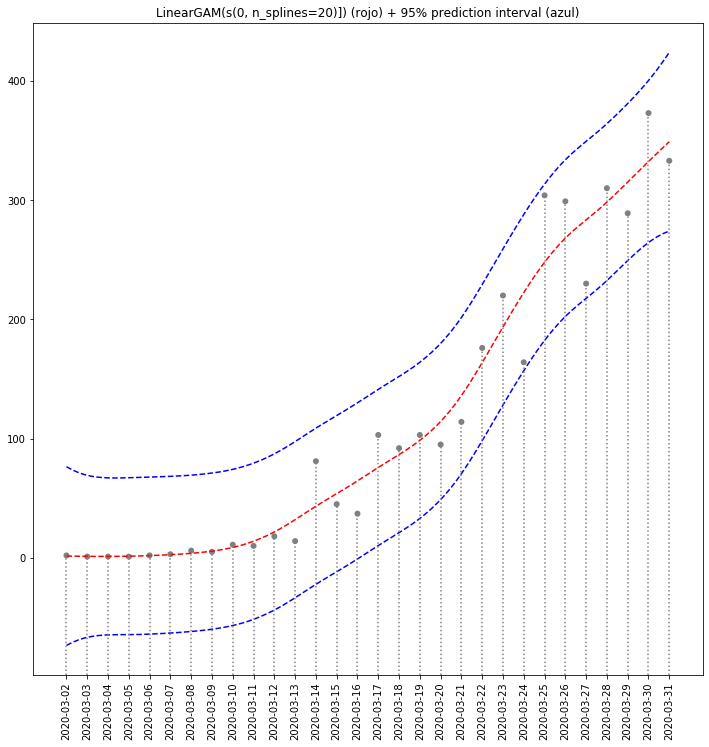

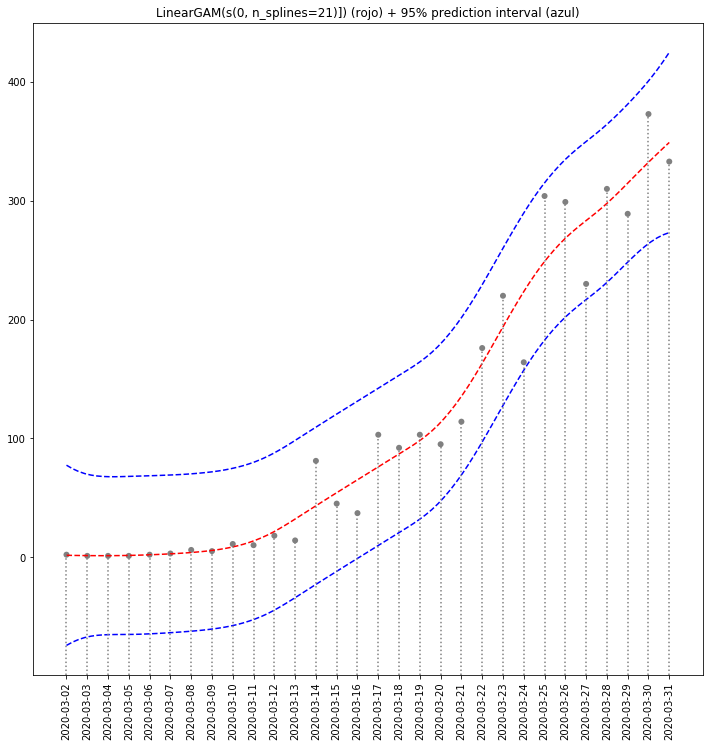

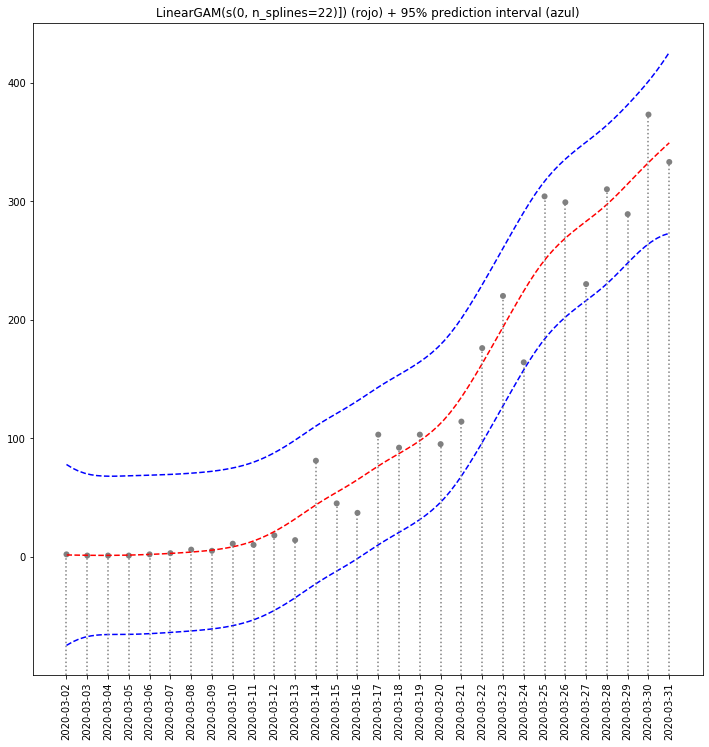

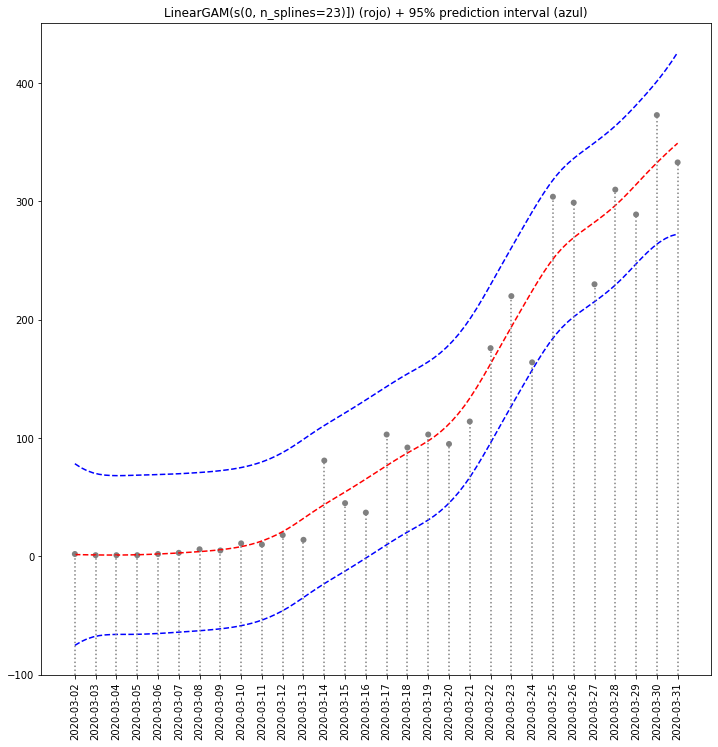

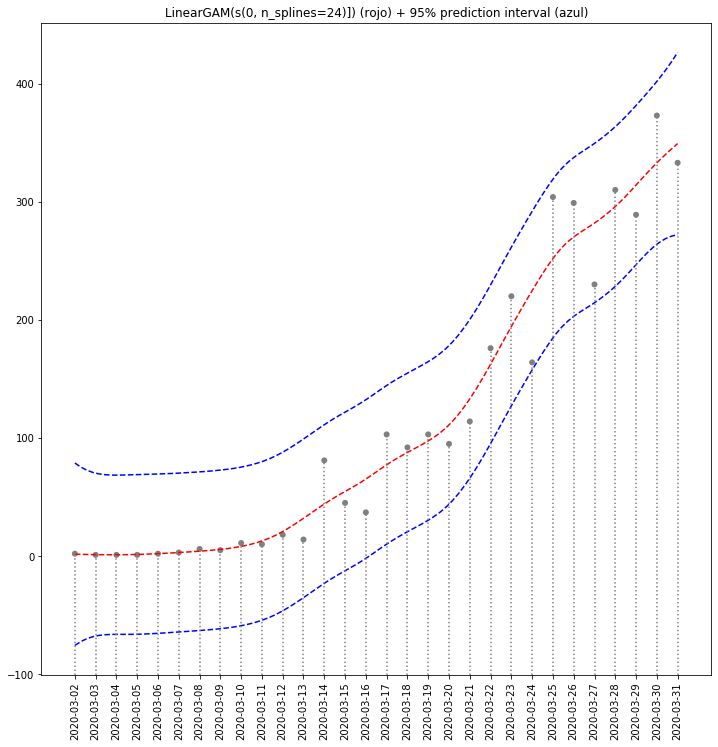

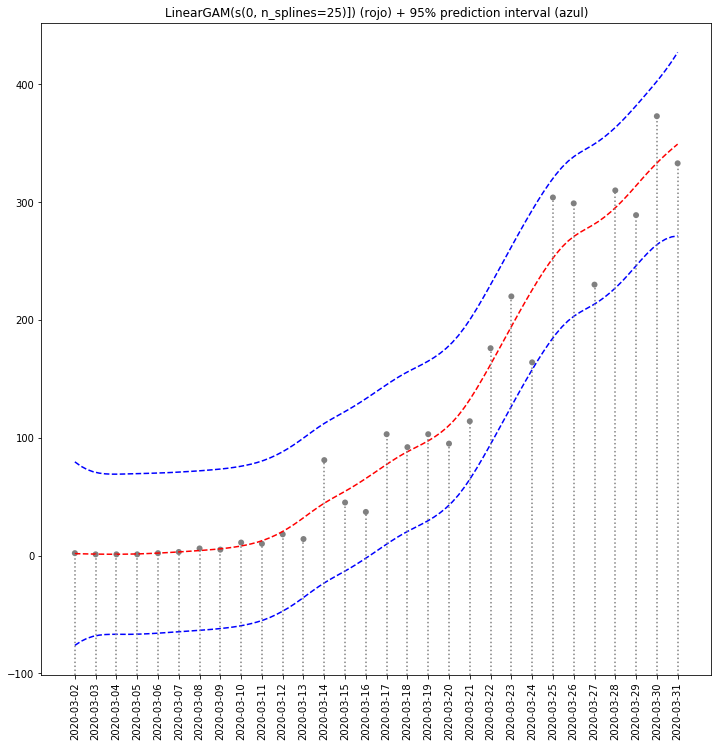

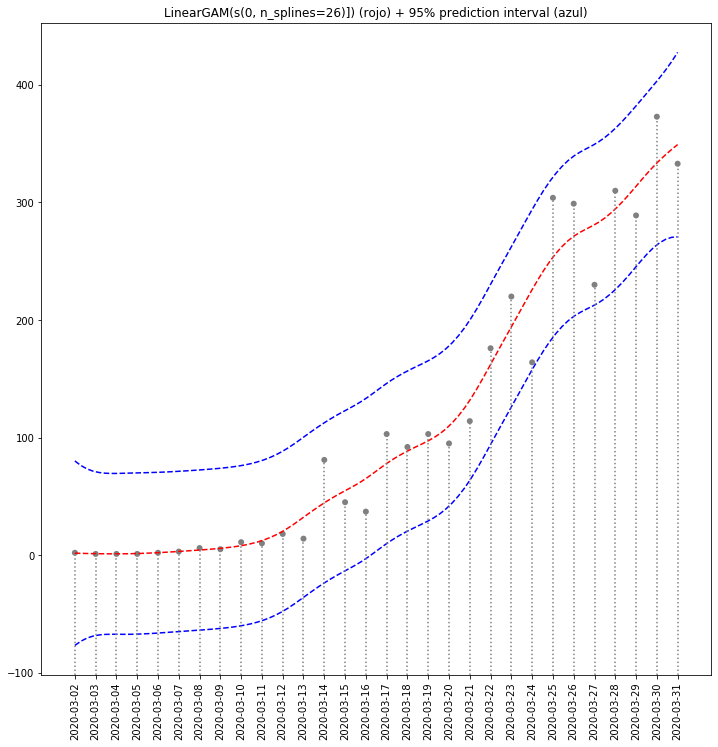

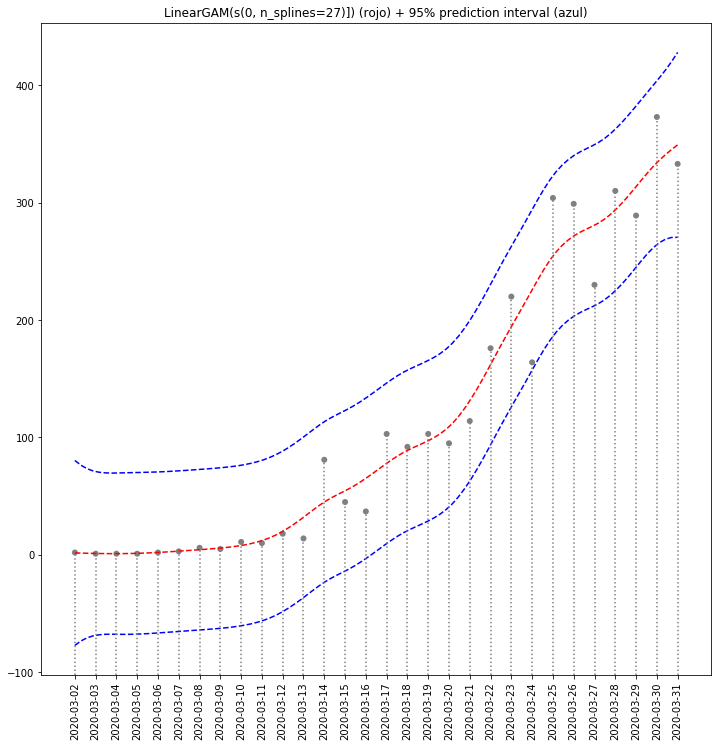

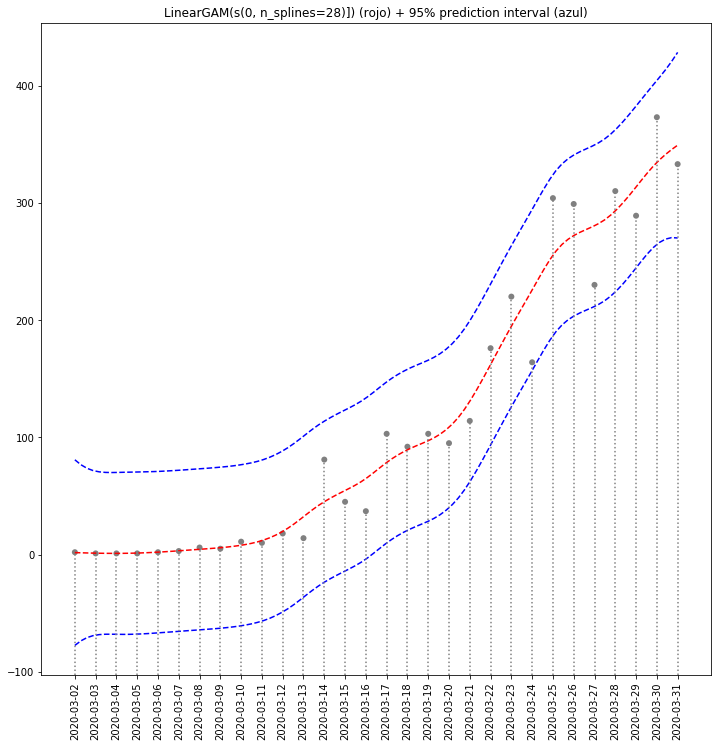

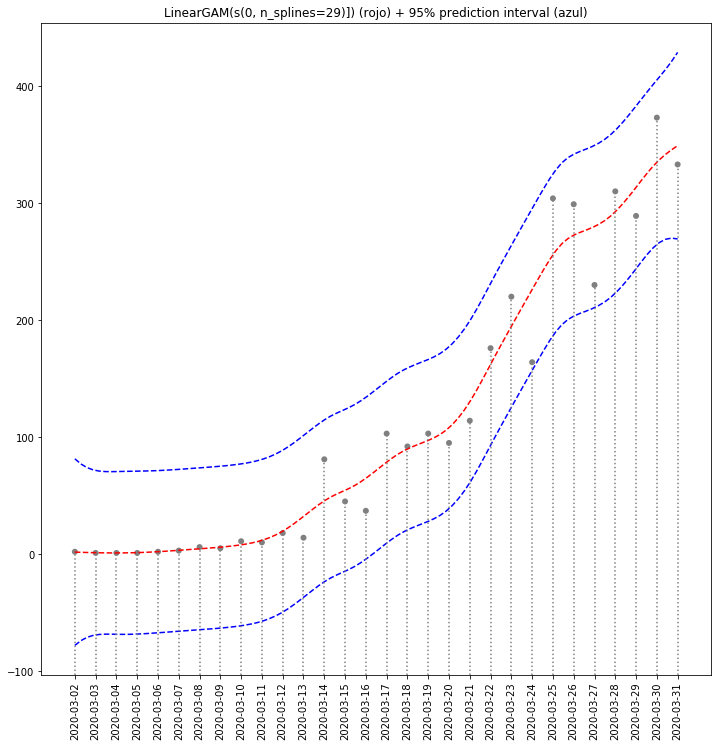

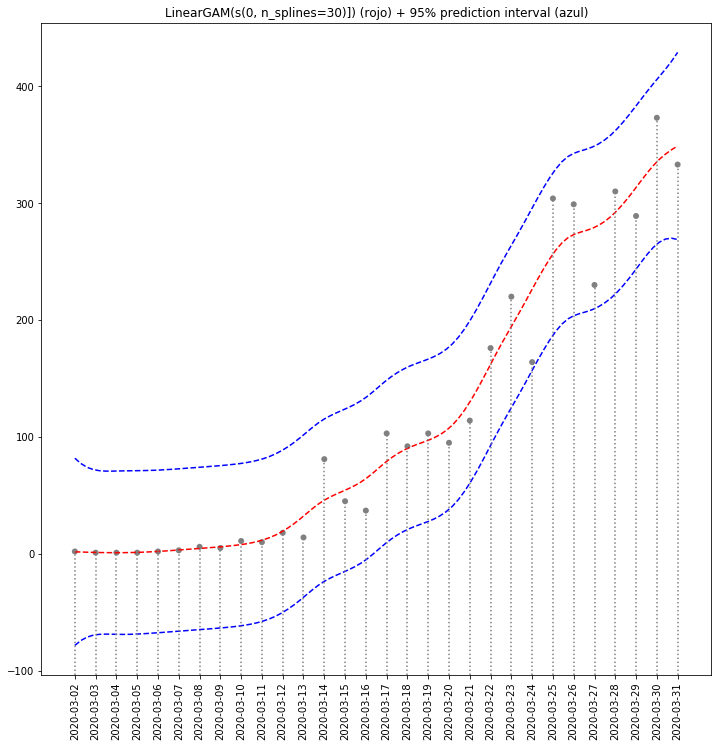

In [518]:
# Miremos un rango
# Veremos modelos muy generales donde no se pueden ver sub-tendencias clararas por un lado
# y modelos overfited por el otro donde cada variación se sobre interpreta mucho.
# La idea es entender como se comporta el modelo en un rango de hiper-parametros

for n_splines in range(10, 31):
    gam = LinearGAM(s(0, n_splines=n_splines))
    gam.fit(X, y)
    plot_gam(gam, f'LinearGAM(s(0, n_splines={n_splines})]) (rojo) + 95% prediction interval (azul)', df.ds, y, True)

In [411]:
# Miremos los coeficientes
gam.coef_

array([-112.96461213, -113.65370597, -114.26508389, -114.47516062,
       -114.08648256, -113.04147499, -111.57646036, -110.17117939,
       -108.62774322, -106.18713111, -100.30918027,  -87.77890109,
        -69.88728372,  -61.94852799,  -53.18724201,  -34.52072914,
        -23.25079344,  -17.88811682,   -6.47936044,   22.99972527,
         61.58376372,   93.29951866,  130.04346273,  158.11289992,
        160.44314562,  170.93048234,  193.84923891,  220.93329525,
        234.26995346,  243.19460638,  115.36092309])